In [81]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("xinwangcs/stressor-cause-of-mental-health-problem-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\user\.cache\kagglehub\datasets\xinwangcs\stressor-cause-of-mental-health-problem-dataset\versions\1


In [82]:
import pandas as pd
import numpy as np
import os
FILES = []
for file in os.listdir(path):
    if file.endswith(".json"):
        PATH = os.path.join(path, file)
        FILES.append(PATH )
print("Files in dataset:", FILES)



Files in dataset: ['C:\\Users\\user\\.cache\\kagglehub\\datasets\\xinwangcs\\stressor-cause-of-mental-health-problem-dataset\\versions\\1\\stressor_test.json', 'C:\\Users\\user\\.cache\\kagglehub\\datasets\\xinwangcs\\stressor-cause-of-mental-health-problem-dataset\\versions\\1\\stressor_train.json']


In [83]:
import json

def load_data2dataframe(file):
    """
    讀取 JSON 文件並將其轉換為 Pandas DataFrame。
    參數:
        file (str): 檔案路徑。

    錯誤回報:
        ValueError: 如果在資料集目錄中找不到 JSON 檔案。
        ValueError: 如果指定的 JSON 檔案不存在。
        
    回傳:
        pd.DataFrame: 包含文本、壓力源類別、壓力源詞和時間間隔的 DataFrame。
    """
    if not FILES:
        raise ValueError("No JSON files found in the dataset directory.")
    if not os.path.exists(file):
        raise ValueError(f"File '{file}' does not exist.")
    with open(file, encoding="utf-8") as f:
        data = json.load(f)
        if not isinstance(data, list):
            raise ValueError(f"Expected a list in JSON file, got {type(data)}")
        temp = []
        for item in data:
            #print(item)
            TEXT = item["text"]
            INTERVAL = item["interval"]
            try:
                STRESSOR_class = item["labels"][0][0]
                STRESSOR_WORD = item["labels"][0][4]
            except IndexError:
                STRESSOR_class = np.nan
                STRESSOR_WORD = np.nan
            temp.append((TEXT, STRESSOR_class, STRESSOR_WORD, INTERVAL))

    # Convert list of tuples to DataFrame with column names
    return pd.DataFrame(temp, columns=["text", "stressor_class", "stressor_word", "interval"])

# Ensure each element is a DataFrame before concatenation
dataframes = [load_data2dataframe(f) for f in FILES]
df = pd.concat(dataframes, ignore_index=True)
df.head()

,text,stressor_class,stressor_word,interval
0,Why are there always trivial matters in life t...,T1,financial,8
1,"After celebrating my 21st birthday, I truly fe...",T1,urged to marry,8
2,"In the coming March, my work pressure will be ...",T1,work,8
3,"Indeed, the pressure of writing papers now is ...",T1,papers,8
4,"I can't learn it anymore, so let's just give u...",T1,can't learn it,8


In [84]:
df.dropna(inplace=True)
df.isna().sum()

text              0
stressor_class    0
stressor_word     0
interval          0
dtype: int64

In [85]:
df_copy = df.copy()

In [ ]:
import gensim
from gensim.parsing.preprocessing import remove_stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string

# 載入 lemmatizer
lemmatizer = WordNetLemmatizer()

def normalize(text):
    # 1. 轉小寫
    text = text.lower()
    # 2. 去標點
    text = text.translate(str.maketrans('', '', string.punctuation))
    # 3. 去停用詞
    text = remove_stopwords(text) if len(text.split()) > 1 else text
    # 4. 詞形還原
    tokens = word_tokenize(text)
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized



In [142]:
from gensim.corpora import Dictionary
word_doc = [ normalize(word) for word in df_copy["stressor_word"]]
Dictionary = Dictionary(word_doc)
corpus = [Dictionary.doc2bow(doc) for doc in word_doc]

In [150]:
from gensim.models import Word2Vec

# 假設 corpus 為已斷詞的句子列表（例如 [['financial'], ['urged', 'to', 'marry'], ...]）
model = Word2Vec(sentences=word_doc, 
                 vector_size=100,
                 window=5, 
                 min_count=1, workers=4)

# 取得詞向量
vector = model.wv['urged', 'marry']  # numpy array (100 維)
vector

array([[-3.4795154e-03, -6.2878523e-03,  6.5035331e-03,  9.2578446e-03,
         8.5860528e-03, -8.9673214e-03,  5.3725359e-03,  5.8347830e-03,
         5.7197767e-03, -8.6718341e-03, -6.5230990e-05, -7.3259771e-03,
        -9.1530997e-03,  2.2531885e-03,  9.9740149e-03,  6.3598137e-03,
        -7.2196843e-03,  2.3793562e-03, -4.1873809e-03,  9.7619388e-03,
        -8.9807576e-03,  1.0037597e-02, -6.5020295e-03, -7.1824128e-03,
         1.6646911e-03, -7.4841280e-04, -8.8024102e-03, -1.2383993e-03,
        -7.6526561e-04, -6.5129939e-03,  5.9973421e-03,  3.1403378e-03,
         8.5252346e-03,  7.1898070e-03, -6.9564171e-03,  5.3086067e-03,
         5.5613071e-03,  5.7893638e-03,  5.0247847e-03, -5.3099985e-03,
         4.5097317e-03,  1.1004652e-03,  3.2784323e-05, -6.5756664e-03,
         1.7935757e-03,  5.4053743e-03, -9.5760021e-03,  8.5139051e-03,
         2.8565391e-03,  3.7344615e-04, -3.4623598e-03, -1.7038414e-05,
         6.1856969e-03,  5.1144180e-03, -6.4594466e-03,  8.33249

In [147]:
word_doc[1]

['urged', 'marry']

In [158]:
'marry' in model.wv

True

In [159]:
# 構建每個文本的詞向量平均值作為文本向量集
word_vectors = []
for tokens in word_doc:
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if vectors:
        avg_vector = np.mean(vectors, axis=0)
    else:
        avg_vector = np.zeros(model.vector_size)
    word_vectors.append(avg_vector)

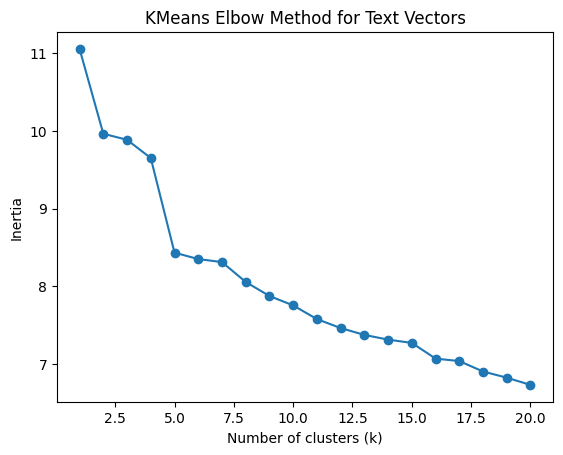

In [163]:
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

# 使用 word_vectors 作為文本向量集
inertia = []
K = range(1, 21)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(word_vectors)
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('KMeans Elbow Method for Text Vectors')
plt.show()

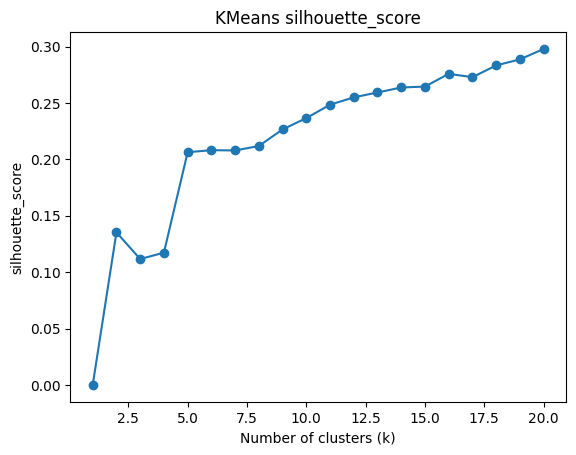

In [ ]:
from sklearn.metrics import silhouette_score

# 使用 word_vectors 作為文本向量集
K = range(1 , 21)
score = []
for k in K :
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(word_vectors)
    labels = kmeans.predict(word_vectors)
    if k == 1:
        score.append(0)
    else:
        score.append(silhouette_score(word_vectors , labels))

plt.plot(K, score, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('silhouette_score')
plt.title('KMeans silhouette_score')
plt.show()